Text(0, 0.5, '|amplitude|')

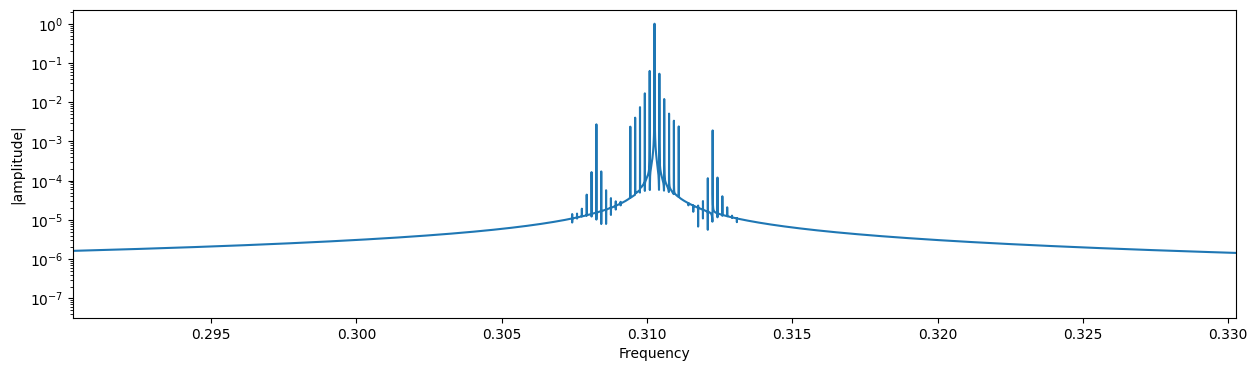

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.stats as sciStat


import PySUSSIX.f90sussix.f90sussix as f90sussix
from PySUSSIX.f90sussix.sussix import  F90Sussix

import PySUSSIX.crosssussix.crossroutines as crossroutines
import PySUSSIX.crosssussix.crosssussix as crosssussix
import PySUSSIX.crosssussix.crossref as crossref

import PySUSSIX.ducksussix.ducksussix as ducksussix


# Creating dummy x,px
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(len(x))

    # Cropping signal to closest power of 2
    Nt      = len(x)
    crop_at = 2**int(np.log2(Nt))



    
    spectrum = np.fft.fft(x[:crop_at])
    freq     = np.fft.fftfreq(turns[:crop_at].shape[-1])

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]



Q0 = 0.31025793875089835
Qs = 0.002
dQ = Qs/12
Jx = (0.5*(10**2))

n_bands_Qs = 1
n_bands_dQ = 5
N   = np.arange(int(1e7))
j   = np.arange(-n_bands_Qs,n_bands_Qs+1)
i   = np.arange(-n_bands_dQ,n_bands_dQ+1)



Ai  = sciStat.cauchy.pdf(i/np.max(i),0,0.05)
Aj  = sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai  = Ai/np.max(Ai)
Aj  = Aj/np.max(Aj)
np.random.seed(0)
phii = np.zeros(len(i))#np.random.uniform(-np.pi/2,np.pi/2,len(i))
phij = np.zeros(len(j))#np.random.uniform(-np.pi/2,np.pi/2,len(j)) 
# x = sum([sum([ _Ai*_Aj * np.sin(2*np.pi*(Q0+ _j*Qs + _i*dQ)*N) for _i,_Ai in zip(i,Ai) ]) for _j,_Aj in zip(j,Aj) ])
hx_full = sum([sum([ np.sqrt(2*Jx)*_Ai*_Aj * np.exp(1j*2*np.pi*(Q0+ _j*Qs + _i*dQ)*N + _phii + _phij) for _i,_Ai,_phii in zip(i,Ai,phii) ]) for _j,_Aj,_phij in zip(j,Aj,phij) ])
x  = hx_full.real
px = hx_full.imag

expected = pd.DataFrame({'amplitude':np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai,_phii in zip(i,Ai,phii) ] for _j,_Aj,_phij in zip(j,Aj,phij) ]).flatten(),
                         'frequency':np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai,_phii in zip(i,Ai,phii) ] for _j,_Aj,_phij in zip(j,Aj,phij) ]).flatten()})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)
# plt.figure()
# plt.plot(x,px,'o',alpha=0.002)
# plt.axis('square')
# plt.xlabel('x')
# plt.ylabel('px')


plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(hx_full)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.xlabel('Frequency')
plt.ylabel('|amplitude|')

# plt.figure(figsize=(15,4))
# freq,spectrum = get_FFT(x)
# plt.plot(freq,spectrum/np.max(spectrum),'-')
# plt.yscale('log')
# # plt.xlim(Q0-10*dQ,Q0+10*dQ)
# plt.xlim(Q0-1*Qs,Q0+1*Qs)
# plt.xlabel('Frequency')
# plt.ylabel('|amplitude|')

# display(expected)


---
# Convergence study
---

array([  1000,   1047,   1097,   1149,   1204,   1261,   1321,   1384,
         1450,   1519,   1592,   1668,   1747,   1830,   1917,   2009,
         2104,   2205,   2310,   2420,   2535,   2656,   2782,   2915,
         3053,   3199,   3351,   3511,   3678,   3853,   4037,   4229,
         4430,   4641,   4862,   5094,   5336,   5590,   5857,   6135,
         6428,   6734,   7054,   7390,   7742,   8111,   8497,   8902,
         9326,   9770,  10235,  10722,  11233,  11768,  12328,  12915,
        13530,  14174,  14849,  15556,  16297,  17073,  17886,  18738,
        19630,  20565,  21544,  22570,  23644,  24770,  25950,  27185,
        28480,  29836,  31257,  32745,  34304,  35938,  37649,  39442,
        41320,  43287,  45348,  47508,  49770,  52140,  54622,  57223,
        59948,  62802,  65793,  68926,  72208,  75646,  79248,  83021,
        86974,  91116,  95454, 100000])

In [31]:
N = int(1e4 )
results = ducksussix.datspe(    x       = x[:N], 
                                px      = px[:N],
                                y       = None,
                                py      = None,
                                zeta    = None,
                                pzeta   = None,
                                number_of_harmonics = 2*len(expected),Hann_order = 1)

In [33]:
results['x'].loc[25:45]

,amplitude,frequency
25,0.001865-0.007152j,0.309908
26,0.002420+0.006970j,0.310611
27,-0.001695+0.005611j,0.310509
28,-0.004620-0.003411j,0.310124
29,-0.002427-0.005158j,0.310029
30,0.003041-0.002730j,0.311025
31,-0.004181-0.002253j,0.310193
32,-0.006114+0.001123j,0.310318
33,-0.003756+0.003367j,0.310414
34,0.002264+0.003618j,0.310692


In [2]:

x,px = hx_full.real,hx_full.imag
N_vec = np.logspace(3,5,100).astype(int)

freq_df = []
amp_df = []
exc_df = []
for N in N_vec:
    results = ducksussix.datspe(x       = x[:N], 
                                px      = px[:N],
                                y       = None,
                                py      = None,
                                zeta    = None,
                                pzeta   = None,
                                number_of_harmonics = len(expected),Hann_order = 1)

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    # tol_freq = dQ
    found = results['x'].copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :#+ 0.8*(tol_freq)**2:
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_a = pd.DataFrame({f'Err_amp:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}'] = row['frequency']
            df_a.loc[N,f'Err_amp:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])


    # saving results
    freq_df.append(df_f)
    amp_df.append(df_a)
    exc_df.append(df_exc)


df_freq = pd.concat(freq_df)
df_amp  = pd.concat(amp_df)
df_exc  = pd.concat(exc_df)

---
# Plotting
---

(2e-06, 10.0)

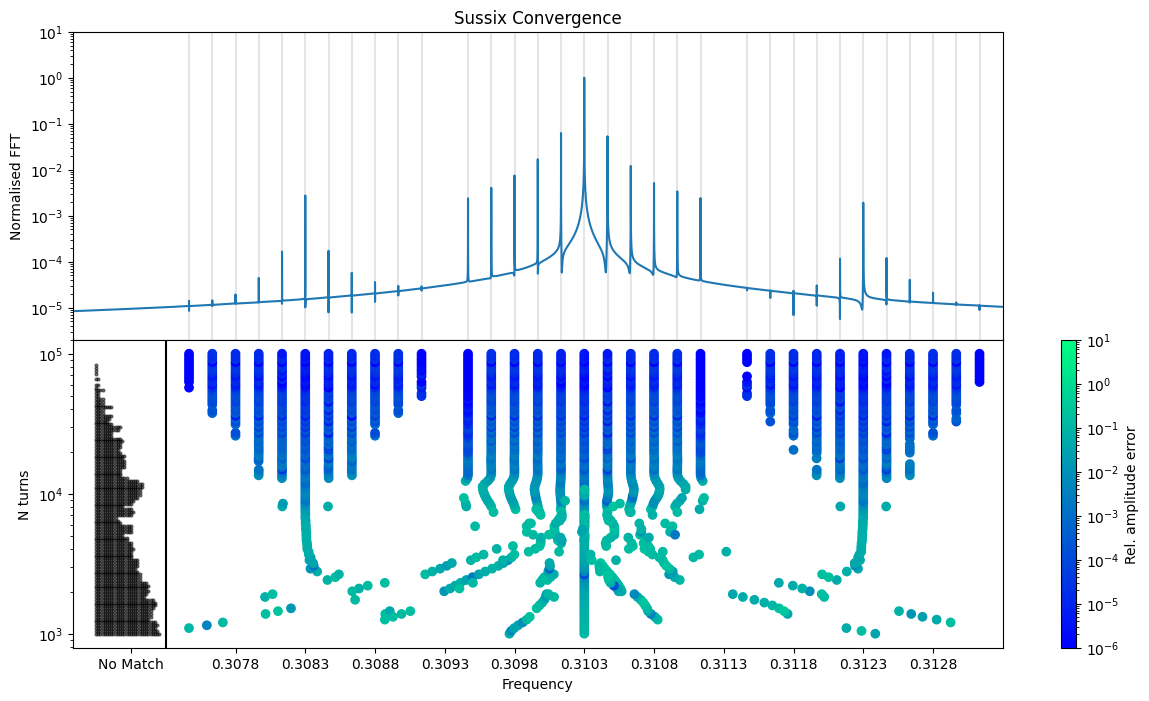

In [21]:
import matplotlib.colors as colors
vmin = 1e-6
vmax = 1e1
fig, axs = plt.subplots(2, 1,figsize=(15,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
axs[0].set_title('SUSSIX Convergence')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_amp[f'Err_amp:{idx}'],norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                                                cmap='winter')
plt.colorbar(label='Rel. amplitude error')

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);


plt.sca(axs[0])
freq,spectrum = get_FFT(hx_full)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Normalised FFT')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e1)

---
# NAFFLib comparison
---

In [22]:

import NAFFlib
import gc
import importlib


x,px = hx_full.real,hx_full.imag
N_vec = np.logspace(3,5,100).astype(int)

freq_df = []
amp_df = []
exc_df = []
naff_Q = 0
naff_A = 0
for N in N_vec:

    importlib.reload(NAFFlib)
    del(naff_Q)
    del(naff_A)
    gc.collect()

    def NAFFlib_tune(x,nfreqs = 1,Hann_order=1):
            x        = np.array(x)
            Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)

            if nfreqs ==1:
                return Q[0]
            else:
                
                return Q,np.abs(A)
            
    naff_Q,naff_A = NAFFlib_tune(hx_full[:N],nfreqs=len(expected),Hann_order=1)
    naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    # tol_freq = dQ
    found = naff_results.copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :#+ 0.8*(tol_freq)**2:
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_a = pd.DataFrame({f'Err_amp:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}'] = row['frequency']
            df_a.loc[N,f'Err_amp:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])


    # saving results
    freq_df.append(df_f)
    amp_df.append(df_a)
    exc_df.append(df_exc)


df_freq = pd.concat(freq_df)
df_amp  = pd.concat(amp_df)
df_exc  = pd.concat(exc_df)

(2e-06, 10.0)

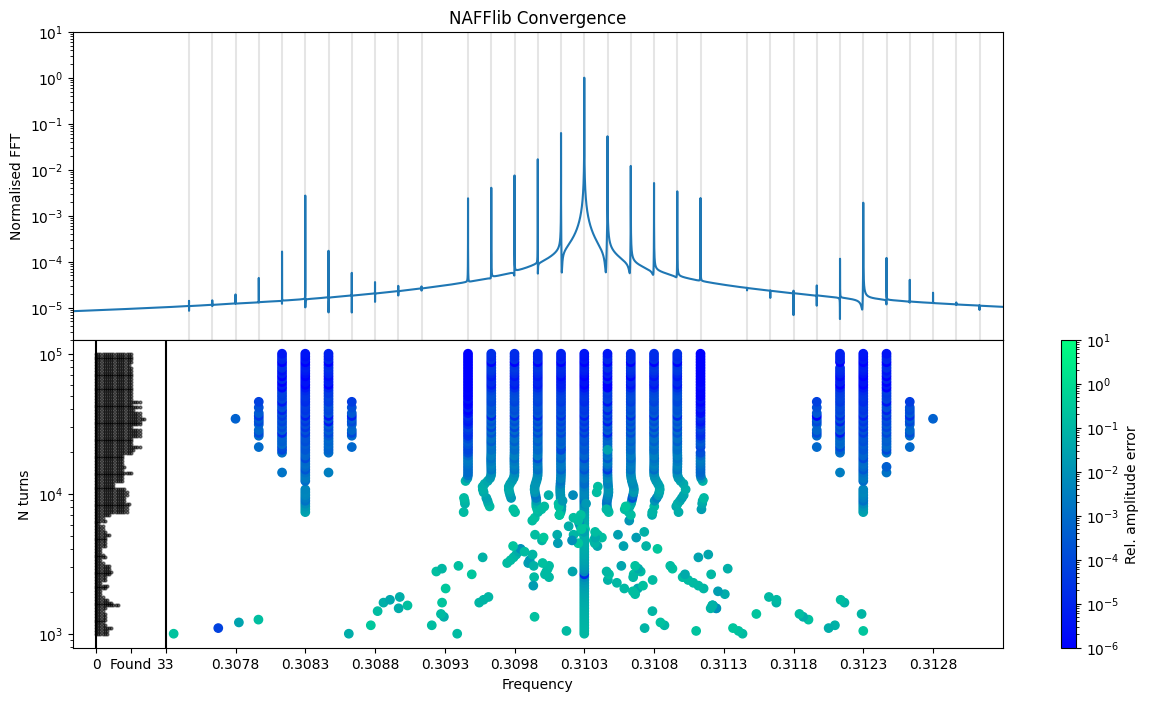

In [41]:
import matplotlib.colors as colors
vmin = 1e-6
vmax = 1e1
fig, axs = plt.subplots(2, 1,figsize=(15,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
axs[0].set_title('NAFFlib Convergence')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_amp[f'Err_amp:{idx}'],norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                                                cmap='winter')
plt.colorbar(label='Rel. amplitude error')

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);


plt.sca(axs[0])
freq,spectrum = get_FFT(hx_full)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Normalised FFT')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e1)

In [198]:
sorted(expected.frequency.values)[::5]

[0.307424605417565,
 0.30825793875089835,
 0.3090912720842317,
 0.3100912720842317,
 0.310924605417565,
 0.311924605417565,
 0.31275793875089836]

In [145]:
df_exc

,excluded
1000,30
1047,29
1097,28
1149,29
1204,28
...,...
83021,1
86974,0
91116,0
95454,0


In [69]:
amp_error

0       0.560069
1       0.772190
2       1.230537
3       2.823299
4      15.999531
5       0.941178
6       0.738488
7       0.551781
8       0.435885
9       0.359103
10    399.999738
11      0.560069
12      0.772190
13      1.230546
14      2.823413
15     15.999532
16      0.999972
17      0.999865
18      2.823299
19      1.230537
20      0.772190
21      0.560069
22    399.999825
23      0.359103
24      0.435885
25      0.551781
26      0.738488
27      0.941178
28     15.999531
29      2.823299
30      1.230537
31      0.772190
32      0.560069
Name: amplitude, dtype: float64

In [70]:
amp_goal

0      0.000062
1      0.000097
2      0.000172
3      0.000384
4      0.001467
5      0.024938
6      0.001467
7      0.000384
8      0.000172
9      0.000097
10     0.000062
11     0.024938
12     0.038911
13     0.068966
14     0.153846
15     0.588235
16    10.000000
17     0.588235
18     0.153846
19     0.068966
20     0.038911
21     0.024938
22     0.000062
23     0.000097
24     0.000172
25     0.000384
26     0.001467
27     0.024938
28     0.001467
29     0.000384
30     0.000172
31     0.000097
32     0.000062
Name: amplitude, dtype: float64

In [67]:
results['x']

,amplitude,frequency
0,9.999724+0.000000j,0.310258
1,0.588217+0.000073j,0.310175
2,0.588200-0.000189j,0.310341
3,0.153830-0.000094j,0.310425
4,0.153831+0.000098j,0.310091
5,0.068957+0.000053j,0.310008
6,0.068957-0.000054j,0.310508
7,0.038904-0.000032j,0.310591
8,0.038904+0.000032j,0.309925
9,0.024937-0.000000j,0.308258


(0.30725793875089835, 0.31325793875089836)

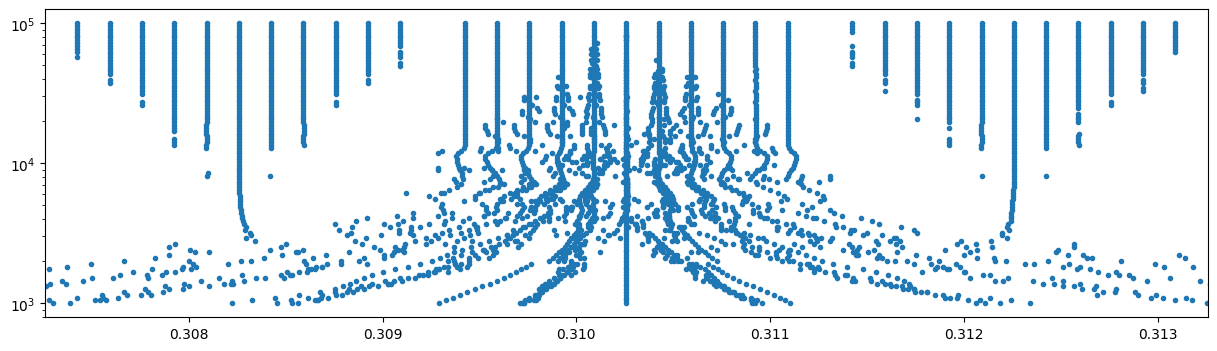

In [31]:
plt.figure(figsize=(15,4))
for col in df.columns:
    plt.plot(df[col],df.index,'.',color='C0')

plt.yscale('log')
plt.xlim(expected.frequency.min()-dQ,expected.frequency.max()+dQ)

In [219]:
import NAFFlib

# naff_Q,naff_A = NAFFlib_tune(hx_full,nfreqs=len(expected),Hann_order=2)
# naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})

import gc
import importlib

importlib.reload(NAFFlib)
del(naff_Q)
del(naff_A)
gc.collect()

def NAFFlib_tune(x,nfreqs = 1,Hann_order=1):
        x        = np.array(x)
        Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)

        if nfreqs ==1:
            return Q[0]
        else:
            
            return Q,np.abs(A)

N = int(1e5)

naff_Q,naff_A = NAFFlib_tune(hx_full[:N],nfreqs=len(expected),Hann_order=1)
naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})


In [213]:
naff_results

,amplitude,frequency
0,10.053494,0.310258
1,0.592766,0.310430
2,0.595524,0.310086
3,0.152612,0.310610
4,0.153011,0.309906
5,0.067366,0.309724
6,0.067308,0.310793
7,0.031353,0.310336
8,0.039345,0.310191
9,0.037276,0.309540


In [40]:
pd.DataFrame({f'freq:{i[0]}':[i[1]] for i in results['x'].frequency.items()},index=[1e5])

,freq:0,freq:1,freq:2,freq:3,freq:4,freq:5,freq:6,freq:7,freq:8,freq:9,...,freq:23,freq:24,freq:25,freq:26,freq:27,freq:28,freq:29,freq:30,freq:31,freq:32
100000.0,0.310258,0.310425,0.310091,0.310591,0.309925,0.310758,0.309758,0.310925,0.309591,0.308258,...,0.308758,0.311758,0.312925,0.307591,0.308925,0.311591,0.313091,0.307425,0.309091,0.311425


(0.3085912720842317, 0.311924605417565)

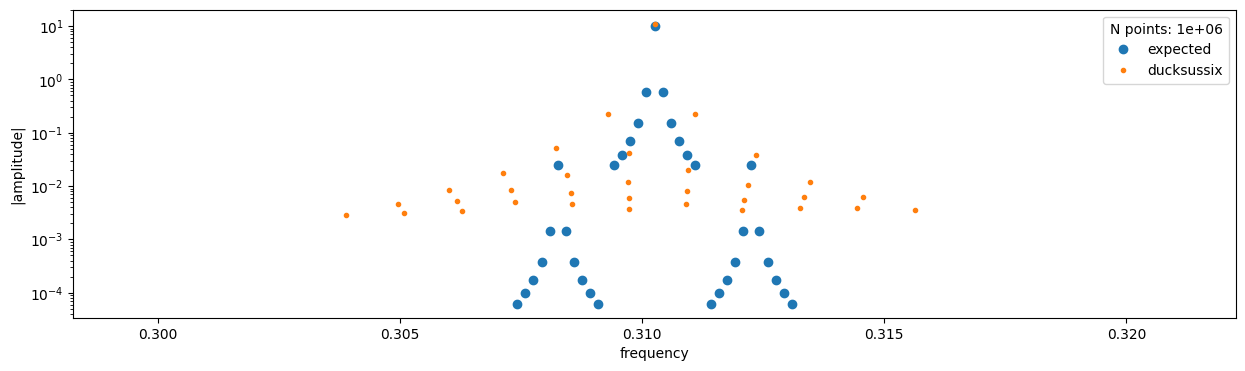

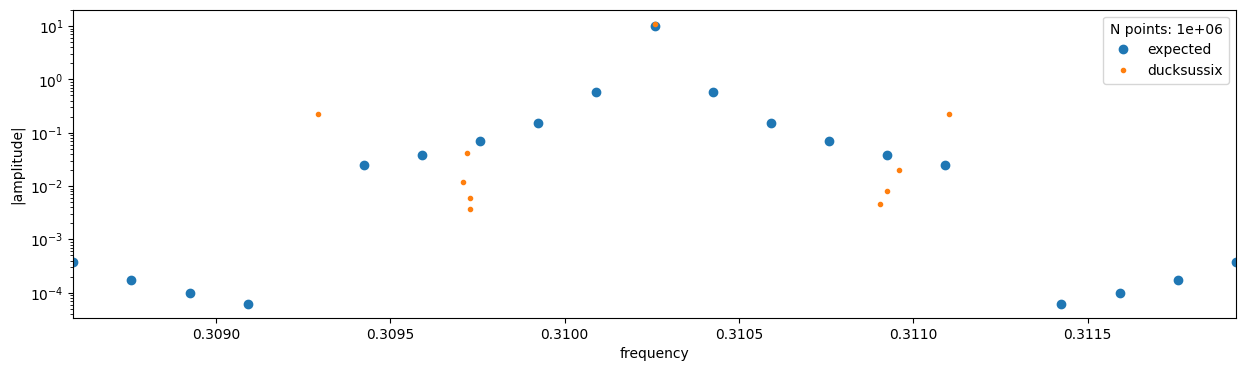

In [146]:

N = int(1e3)
results = ducksussix.datspe(x       = x[:N], 
                                px      = px[:N],
                                y       = None,
                                py      = None,
                                zeta    = None,
                                pzeta   = None,
                                number_of_harmonics = len(expected),Hann_order = 1)

plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
# plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-6*Qs,Q0+6*Qs)

plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
# plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-10*dQ,Q0+10*dQ)

(0.30825793875089835, 0.31225793875089836)

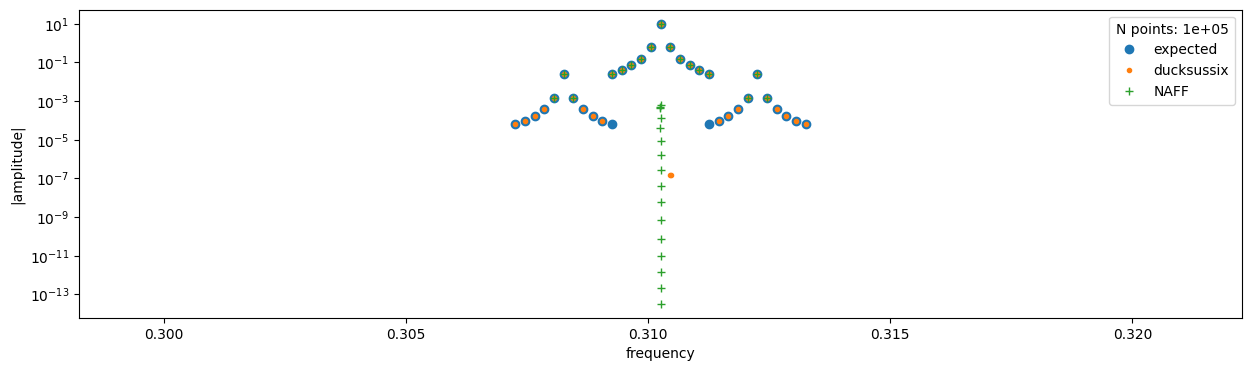

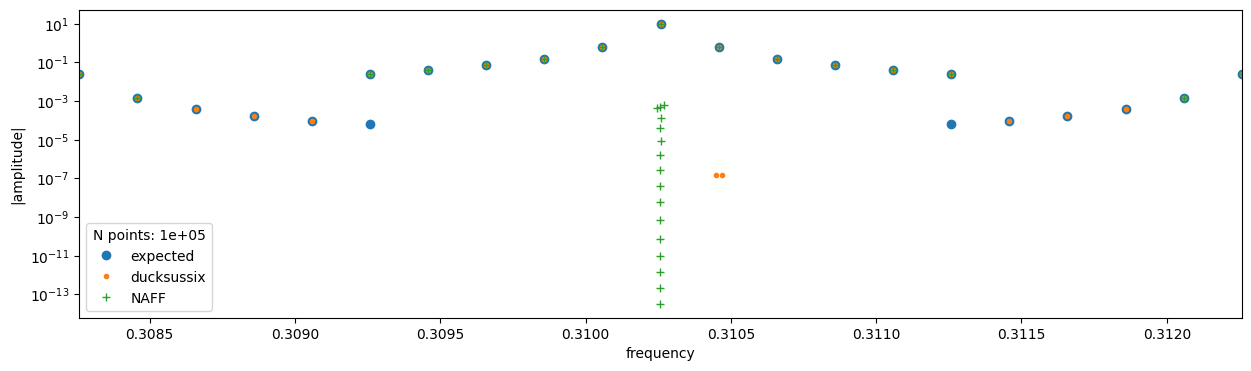

In [20]:
plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-6*Qs,Q0+6*Qs)

plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-10*dQ,Q0+10*dQ)

---
# Root finding
---

In [18]:
test = 0
test.real

0

In [6]:




def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn +1)


    z = (np.array(x) + 1j *np.array(px)) * (1.0 + np.cos(step * (mf_values - maxn2)))

    # N    = np.arange(len(x))
    # z2   = np.array(x) + 1j*np.array(px)
    # z2_w = z# * ducksussix.Hann(N, Nt=len(z),p=1)
    # print(z)
    # print(z2_w)

    # Search for maximum in Fourier spectrum
    # zsing = crossroutines.cfft(z)
    zsing = np.fft.fft(z[:npoint])
    ftmax = np.max(np.abs(zsing[:npoint]))
    nftmax = np.argmax(np.abs(zsing[:npoint]))
    
    tunefou = float(nftmax ) / float(npoint)
    
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)
    deltat = 1.0 / float(npoint)

    
    tune1 = tunefou - deltat
    
    
    # Call zfun
    # print('est:',tune1)
    print('tune1',tune1)
    tune,zw = crossroutines.zfunr(z,tune1)


    # Windowing of the signal
    N   = np.arange(len(x))
    z   = np.array(x) + 1j*np.array(px)
    z_w = z * ducksussix.Hann(N, Nt=len(z),p=1)
    
    # Estimation of the tune with FFT
    tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

    # Preparing the estimate for the Newton refinement method
    if tune_est >= 0.5:
        tune_est = -(1.0 - tune_est)
    tune_est = tune_est - resolution

    # Refinement of the tune calulation
    print('tune_est',tune_est)
    tune,amplitude = crossroutines.zfunr(z_w,tune_est)
    # print(tune,zw)

    # def zfun(tune, z, maxn):
    #     # Implementation of the function z(tune)
    #     # Modify this based on your actual function
    #     ztune = np.exp(-1j * 2 * np.pi * tune.real)
    #     return np.polyval(z[::-1], ztune)

    # def zfund(tune, z, maxn):
    #     # Implementation of the function z(tune)
    #     # Modify this based on your actual function

    #     zd = 1j * np.arange(1, maxn + 1) * z
    #     ztune = np.exp(-1j * 2 * np.pi * tune.real)
    #     return np.polyval(zd[::-1], ztune)



    # # Additional arguments to pass to the function and its derivative
    # args = (z, len(z))

    # # Tolerance for convergence
    # tolerance = 1e-10

    # # Use Newton's method with specified tolerance
    # # from scipy.optimize import newton
    # # result_tune = newton(zfun, tune1,fprime=zfund, args=args)
    # # print(tune1)

    # # print(result_tune)

    return tune,zw


number_of_harmonics = 10
# initialisation
x,px = hx_full.real,hx_full.imag
z  = x + 1j*px
N  = np.arange(len(x))


frequencies = []
amplitudes  = [] 
for _ in range(number_of_harmonics):

    # Computing frequency and amplitude
    print('**')
    print(_)
    # freq,zw = tunenewt(x,px)
    # print(freq,zw)
    freq,zw  = ducksussix.fundamental_frequency(x,px,Hann_order=1)
    print(freq,zw)
    freq2,zw2 = crossroutines.tunenewt(x,px)
    print(freq2,zw2)
    print(40*'-')
    # freq,zw = crossroutines.tunenewt(x,px)
    zpesi   = zw #/ max(N+1)

    # Saving results
    frequencies.append(freq)
    amplitudes.append(zpesi)

    # Substraction procedure
    zgs  = zpesi * np.exp(2 * np.pi * 1j * freq * N)
    z   -= zgs
    x,px = np.real(z), np.imag(z)

**
0
0.31025793875089835 (1000000.0000007827+2.154541739526195e-07j)
0.31025793875089835 (1000000.0000007827+2.154541739526195e-07j)
----------------------------------------
**
1
0.31025793875089835 (-99999000000.15466-0.04251434862435168j)
0.31025793875089835 (-99999000000.15369-0.04212878262696553j)
----------------------------------------
**
2
0.31025793875089835 (9999800001023208+6147.429694783992j)
0.31025793875089835 (9999800001023208+6147.429694783992j)
----------------------------------------
**
3
0.31025793875089835 (-9.999700003030671e+20-835685417.1510801j)
0.31025793875089835 (-9.999700003030671e+20-835685417.1510801j)
----------------------------------------
**
4
0.31025793875089835 (9.999600006038164e+25+103412752781784.28j)
0.31025793875089835 (9.999600006038164e+25+103412752781784.28j)
----------------------------------------
**
5
0.31025793875089835 (-9.999500010045642e+30-1.2391091463490056e+19j)
0.3102579387508983 (-9.99950001005609e+30-1.3599056935229599e+20j)
-----

In [18]:
expected.loc[9].frequency

0.30825793875089835

In [6]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

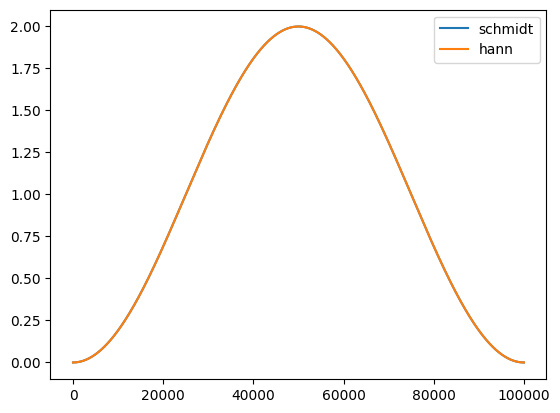

In [16]:
x,px = hx_full.real,hx_full.imag
z  = x + 1j*px

# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn +1)
N   = np.arange(len(x))

window_schmidt = (1.0 + np.cos(step * (mf_values - maxn2)))
window_hann    = ducksussix.Hann(N, Nt=len(z),p=1)

plt.figure()
plt.plot(window_schmidt,'-',label='schmidt')
plt.plot(window_hann,'-',label='hann')
plt.legend()
# # z = (np.array(x) + 1j *np.array(px)) * (1.0 + np.cos(step * (mf_values - maxn2)))

# N    = np.arange(len(x))
# z2   = np.array(x) + 1j*np.array(px)
# z2_w = z# * ducksussix.Hann(N, Nt=len(z),p=1)

In [17]:
mf_values

array([     1,      2,      3, ...,  99998,  99999, 100000])

In [18]:
N

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [14]:
window_hann

array([1.97392092e-09, 7.89568355e-09, 1.77652879e-08, ...,
       7.89568355e-09, 1.97392092e-09, 0.00000000e+00])

In [15]:
window_schmidt

array([1.97392092e-09, 7.89568355e-09, 1.77652879e-08, ...,
       7.89568355e-09, 1.97392092e-09, 0.00000000e+00])

0.31025793875089835 (1000000.0000007827+2.154541739526195e-07j)


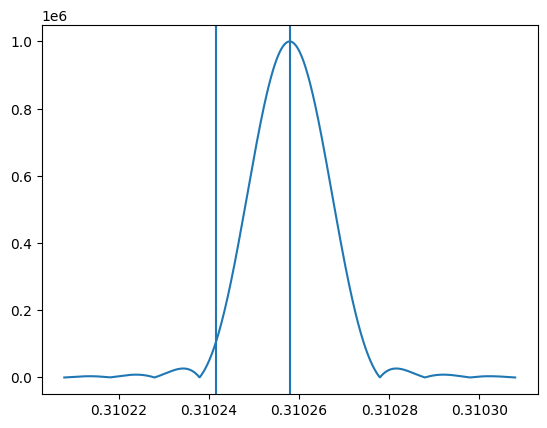

In [144]:
def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.abs(np.polyval(z[::-1], ztune))

x,px = hx_full.real,hx_full.imag
z  = x + 1j*px
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn +1)

freq,zw = tunenewt(x,px)


# Search for maximum in Fourier spectrum
# zsing = crossroutines.cfft(z)
zsing = np.fft.fft(z[:npoint])
ftmax = np.max(np.abs(zsing[:npoint]))
nftmax = np.argmax(np.abs(zsing[:npoint]))

tunefou = float(nftmax ) / float(npoint)

if tunefou >= 0.5:
    tunefou = -(1.0 - tunefou)
deltat = 1.0 / float(npoint)


tune1 = tunefou - deltat

z = (np.array(x) + 1j *np.array(px)) * (1.0 + np.cos(step * (mf_values - maxn2)))


f_test = np.linspace(freq-0.5e-4,freq+0.5e-4,1000)

value = [zfun(_f,z,len(z)) for _f in f_test]

plt.figure()
plt.plot(f_test,value)
plt.axvline(freq)
plt.axvline(tune1)

In [140]:
tune1

0.31024169921875

(0.31020793875089836, 0.31030793875089835)

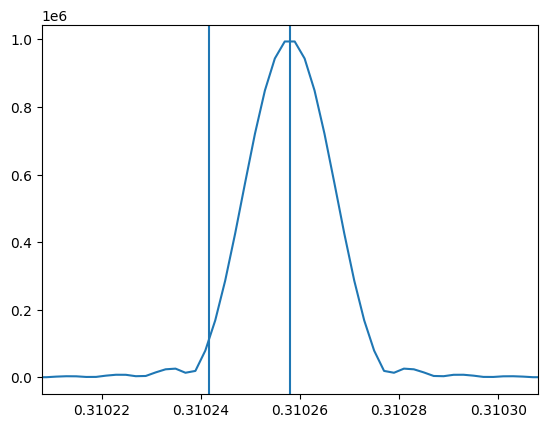

In [102]:
plt.figure()
plt.plot(f_test,value)
plt.axvline(freq)
plt.axvline(tune1)
plt.xlim(freq-0.5e-4,freq+0.5e-4)

In [82]:
tune1

0.31024169921875

In [138]:

scaling = 1e6
from scipy.optimize import minimize
def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune/scaling)
    return np.log(np.abs(np.polyval(z[::-1], ztune)))

def zfund(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function

    zd = 1j * np.arange(1, maxn + 1) * z
    ztune = np.exp(-1j * 2 * np.pi * tune/scaling)
    return np.log(np.abs(np.polyval(zd[::-1], ztune)))


args = (z, len(z))
results = minimize(zfun, x0=[tune1*scaling],jac=zfund, args=args)#,  bounds=[((tune1-1e-4)*scaling,(tune1+1e-4)*scaling)]))

In [139]:
print(results.x[0]/scaling)
print(freq)

0.31022048921875
0.31025793875089835


In [3]:



x,px = hx_full.real,hx_full.imag
print(ducksussix.tunenewt(x,px,hanning_order = 1))
print(crosssussix.tunenewt(x,px,hanning_order = 1))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:


for part in [dummy,particle0,particle1]:
    x,px = part.x_sig,part.px_sig
    print(40*'-')
    print(ducksussix.tunenewt(x,px))
    print(crossroutines.tunenewt(x,px))

----------------------------------------
(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))
(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))
----------------------------------------
(-0.31481146763892404, (-23401.79975299315+99460.63001598419j))
(-0.3148114676389241, (-23401.7997531048+99460.63001600423j))
----------------------------------------
(-0.31489727277909013, (52060.822822896924+62772.4182559299j))
(-0.31489727277909013, (52060.822822896924+62772.4182559299j))


In [ ]:
part  = dummy
datspe_x,datspe_y,datspe_s = crosssussix.datspe(part.x_sig,part.px_sig,
                            part.y_sig,part.py_sig,
                            part.zeta_sig,part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning',return_values = True)
ordres_x,ordres_y,ordres_s  = crosssussix.ordres(len(part.x_sig),tune_estimate = [0.31,0.32,0.0018],number_of_harmonics = 5,return_values = True)
part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
# results['x']
display('cross DATSPE X',datspe_x)
display('duck DATSPE X',results['x'])
# display('DATSPE S',datspe_s)
display('ORDRES X',ordres_x)
# display('ORDRES Y',ordres_y)
# display('ORDRES S',ordres_s)

 Y TUNE DIFFERENT FROM EXPECTED
  0.32026399999999999      -0.32000000000000001     
 EXPECTED TUNE Y NOT FOUND
 LINE 1 ASSUMED AS TUNE!!!


'cross DATSPE X'

,zxpes,txa
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01+1.869515e- 13j,-0.389490
2,-1.660121e-12-1.153461e- 12j,0.310334
3,1.353238e-12-1.346130e- 13j,0.310176
4,-8.767324e-13-4.034402e- 15j,-0.242232


'duck DATSPE X'

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


'ORDRES X'

,j,k,l,m,ax,fx,ox
0,1,0,0,0,5.000000e+00,1.395755e-12,-0.310258
1,3,1,0,-1,2.500000e-01,7.478059e-13,0.389490
2,0,0,0,0,2.021503e-12,-2.534362e+00,-0.310334
3,0,0,0,0,1.359917e-12,-9.914859e-02,-0.310176
4,0,0,0,0,8.767417e-13,-3.136991e+00,0.242232


(-15.0, 15.0)

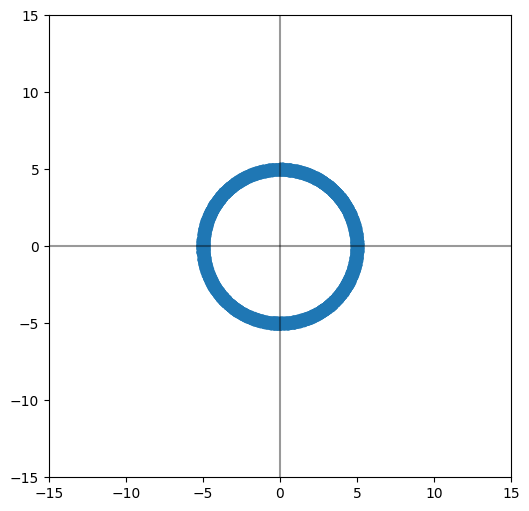

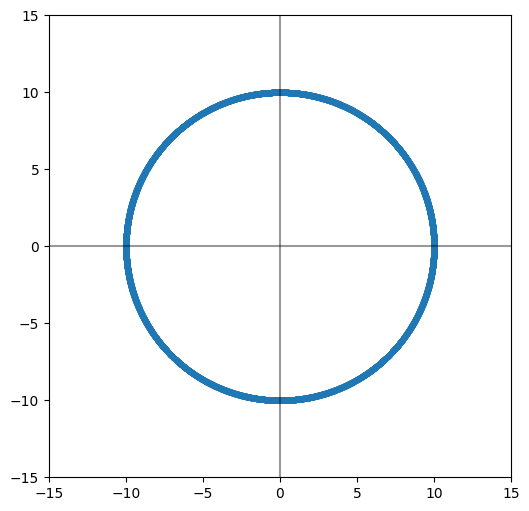

In [ ]:
particle0 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_0.parquet')
particle1 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_1.parquet')

dummy = particle0.copy()


turns = int(10000)
N     = np.arange(0,turns)

Qx    = 0.31025793875089835
Qy    = 0.320264
Jx    = 0.5**2*(0.5*(10**2))
Jy    = (0.5*(10**2))
psi0  = 0#0.25

# mn = [(1,0),(-2,0)]

#  jQ_x + kQ_y + l*Q_z + m
jklm = [(0,0,0,0),(0,2,1,0)] 
aj = [np.sqrt(2*Jx),0.02*Jx,0.02*Jx,0.02*Jx]
phasors = sum([a*np.exp(2*np.pi*1j*((1-j+k)*Qx + (m-l)*Qy)*N) for (j,k,l,m),a in zip(jklm,aj)])

hx = phasors
x  = hx.real
px = hx.imag

hy = np.sqrt(2*Jy)*np.exp(-1j*(2*np.pi*Qy*N - psi0))
y  = hy.real
py = hy.imag


dummy.particle = 0
dummy.x_sig = x
dummy.px_sig = px
dummy.y_sig = y
dummy.py_sig = py


plt.figure(figsize=(6,6))
plt.plot(x,px,'.')
# plt.plot(hx.real,hx.imag,'.',ms=2)
plt.axhline(0,color='k',alpha=0.4)
plt.axvline(0,color='k',alpha=0.4)
plt.axis('square');
plt.xlim([-15,15])
plt.ylim([-15,15])

plt.figure(figsize=(6,6))
plt.plot(y,py,'.')
# plt.plot(hx.real,hx.imag,'.',ms=2)
plt.axhline(0,color='k',alpha=0.4)
plt.axvline(0,color='k',alpha=0.4)
plt.axis('square');
plt.xlim([-15,15])
plt.ylim([-15,15])


,Q,A
0,0.314811,5.117629
1,0.370377,0.186963
2,0.312945,0.041125
3,0.316678,0.041329
4,0.055566,0.026459


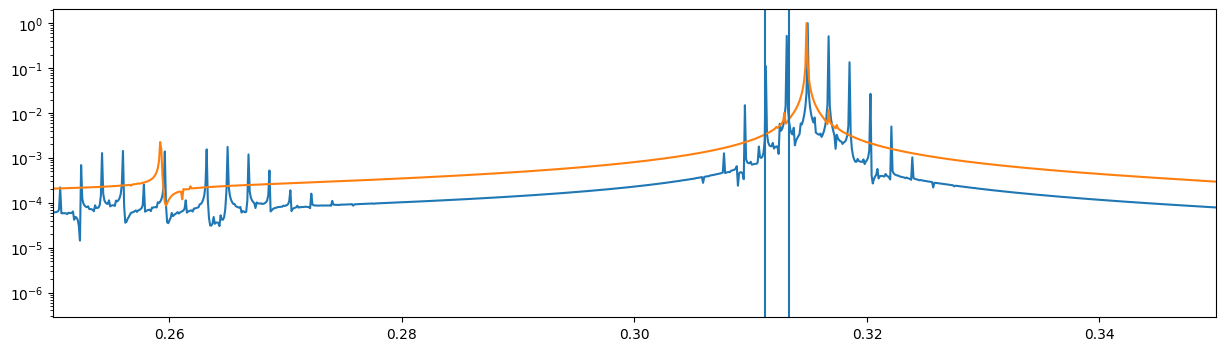

In [ ]:
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(1,len(x)+1)

    freq  = np.fft.fftfreq(turns.shape[-1])
    spectrum = np.fft.fft(x-np.mean(x))

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]




plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(particle1.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')

freq,spectrum = get_FFT(particle0.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')
# plt.plot(Q,A/np.max(A),'o')
plt.yscale('log')
plt.axvline(Qx+0.001)
plt.axvline(Qx+0.001+0.002)
plt.xlim(0.25,0.35)



---
# sidebands
---

In [ ]:
Qx

0.31025793875089835

(0.30825793875089835, 0.31225793875089836)

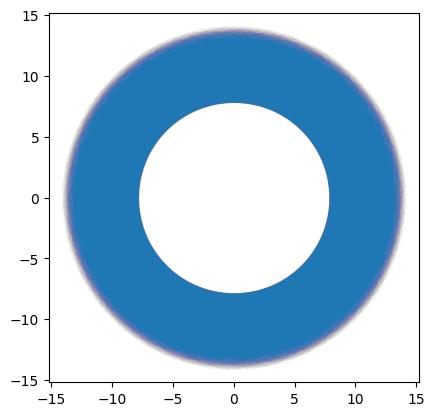

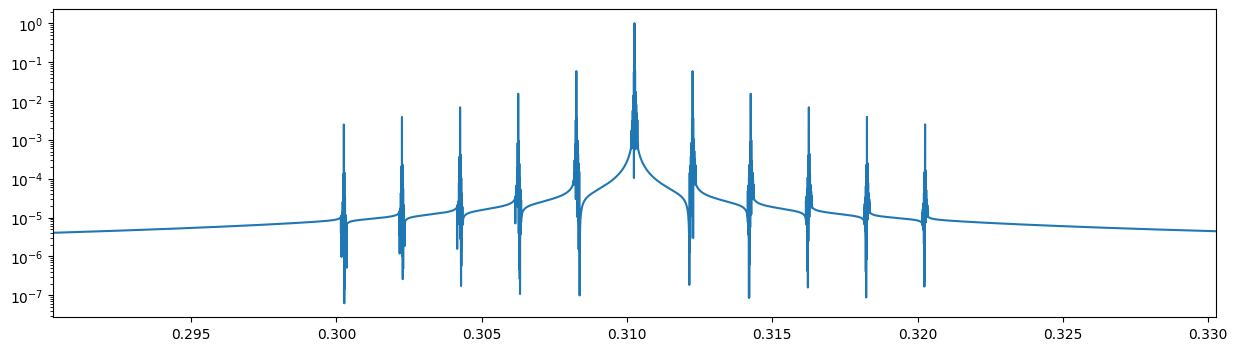

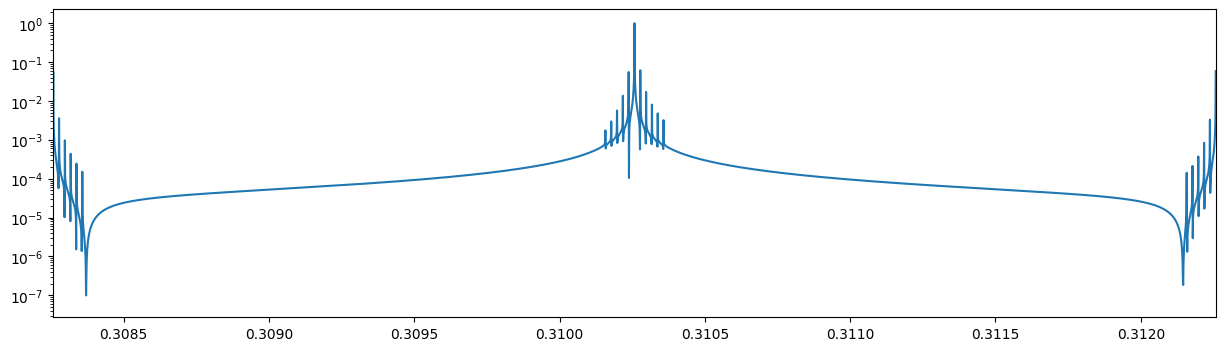

In [ ]:
Q0+dQ

0.3102779387508984

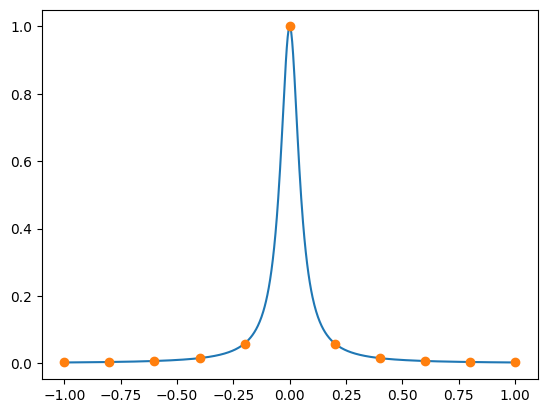

In [3]:
plt.figure()
_x = np.linspace(-1,1,1000)
_x_bands = i/np.max(i)
_y = sciStat.cauchy.pdf(_x,0,0.05)
_y_bands = sciStat.cauchy.pdf(_x_bands,0,0.05)

plt.plot(_x,_y/np.max(_y))
plt.plot(_x_bands,_y_bands/np.max(_y_bands),'o')

In [ ]:
10/(10+i**2) 

array([0.90909091, 1.        , 0.90909091])

In [ ]:
Ai*Aj

array([0.25, 1.  , 0.25])

(0.31, 0.311)

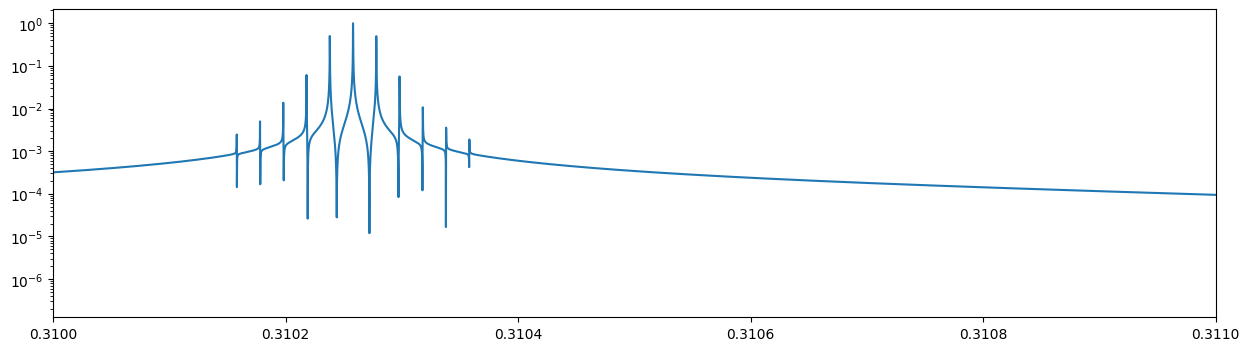

In [ ]:
plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(x)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.yscale('log')
plt.xlim(0.31,0.311)

In [ ]:
freq

array([1.0000e-05, 2.0000e-05, 3.0000e-05, ..., 4.9997e-01, 4.9998e-01,
       4.9999e-01])

---
# Testing main program
---

In [ ]:
SS = F90Sussix()
SS.sussix_inp(nt1   = 1, 
              nt2   = len(particle0.x_sig),
              idam  = 3,
              ir    = 1,
              tunex = 0.31,
              tuney = 0.32,
              istun = None,
              nline = 0)


SS.sussix(  particle0.x_sig,particle0.px_sig,
            particle0.y_sig,particle0.py_sig,
            particle0.zeta_sig,particle0.pzeta_sig,)
df = pd.DataFrame({'ax':SS.ax,'ox':SS.ox,'ay':SS.ay,'oy':SS.oy})#,'y':y,'py':py})
# df = df[df.ox>0]
# df.sort_values('ox',inplace=True)
# df = df.reset_index(drop=True)
df.head(10)

 X TUNE DIFFERENT FROM EXPECTED
 -0.31481147556828426       0.31000000000000000     
 EXPECTED TUNE X FOUND AT LINE           2
 Y TUNE DIFFERENT FROM EXPECTED
 -0.31735353877468614       0.32000000000000001     
 EXPECTED TUNE Y FOUND AT LINE           2
 Y TUNE DIFFERENT FROM EXPECTED
  -1.8660974207716056E-003   1.0000000000000000E-003
 EXPECTED TUNE S FOUND AT LINE           2


,ax,ox,ay,oy
0,5.117726,3.148115e-01,0.130927,3.173535e-01
1,5.117774,-3.148115e-01,0.130927,-3.173535e-01
2,0.186964,3.703771e-01,0.097028,-3.148114e-01
3,0.186975,-3.703771e-01,0.097024,3.148114e-01
4,0.114162,-2.385124e-11,0.027624,3.703770e-01
5,0.041474,3.166784e-01,0.027621,-3.703770e-01
6,0.041472,-3.166784e-01,0.015792,-3.122693e-01
7,0.041379,3.129444e-01,0.015792,3.122693e-01
8,0.041375,-3.129444e-01,0.010707,-5.225744e-12
9,0.026451,-5.556555e-02,0.011567,3.678351e-01


---
# Testing subroutines
---

## spectrum

In [ ]:



cross = crossroutines.spectrum(dummy.x_sig,dummy.px_sig,number_of_harmonics = 5,method = 'hanning',return_values = True)
duck = ducksussix.spectrum(dummy.x_sig,dummy.px_sig,number_of_harmonics = 5,method = 'hanning')
display('CROSS',cross)
display('DUCK',duck)

'CROSS'

,tune,zpesi
0,0.310258,5.000000e+00+6.978777e- 12j
1,-0.389490,2.500000e-01+1.869515e- 13j
2,0.310334,-1.660121e-12-1.153461e- 12j
3,0.310176,1.353238e-12-1.346130e- 13j
4,-0.242232,-8.767324e-13-4.034402e- 15j


'DUCK'

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


In [ ]:
crossroutines.tunenewt(dummy.x_sig,0*dummy.px_sig)

(0.31025793875090096, (24999.999999341908-2.3989512664483018e-06j))

In [ ]:
type(0*1J)

complex

In [ ]:
type(complex(f90sussix.data.zw_out[0].real/len(x)))

complex

In [ ]:
crossroutines.tunelasr(dummy.x_sig,dummy.px_sig)

(0.3102579387778248, (0.0005001000094395693+1.4397897569530925e-11j))


## tunenewt and tunelasr

In [ ]:
dummy

,CHUNK,turn,particle,state,at_element,x_sig,px_sig,y_sig,py_sig,zeta_sig,pzeta_sig
174000,0,0,0,1,0,5.250000,0.000000,10.000000,0.000000,-0.000016,-0.002811
174001,0,1,0,1,0,-2.040272,4.485921,-4.272796,-9.041195,0.000019,-0.002811
174002,0,2,0,1,0,-3.588459,-3.188665,-6.348643,7.726237,0.000055,-0.002811
174003,0,3,0,1,0,4.656971,-2.324784,9.698087,2.438669,0.000090,-0.002810
174004,0,4,0,1,0,0.047992,5.081109,-1.938947,-9.810224,0.000126,-0.002809
...,...,...,...,...,...,...,...,...,...,...,...
1974995,9,9995,0,1,0,5.162086,0.948813,9.706124,-2.406482,-0.002469,0.001920
1974996,9,9996,0,1,0,-2.774436,4.041336,-6.322976,-7.747256,-0.002489,0.001891
1974997,9,9997,0,1,0,-3.000128,-3.770697,-4.302767,9.026971,-0.002508,0.001861
1974998,9,9998,0,1,0,5.013119,-1.452134,9.999945,0.033175,-0.002527,0.001832


In [ ]:
print(crossroutines.tunenewt(dummy.x_sig,dummy.px_sig))
print(crossroutines.tunenewt(dummy.x_sig,0*dummy.px_sig))
print(Qx)

(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j)) zf before         (2.51951707684659839E-314,0.0000000000000000)
 zfd before                        (2.50527091874863490E-314,NaN)
 zf after              (-25290.806259478279,21933.386442385527)
 zfd after             (-66040511.753324687,-164288931.82204562)

(0.31025793875090096, (24999.999999341908-2.3989512664483018e-06j))
0.31025793875089835
 zf before         (2.51951407292747167E-314,0.0000000000000000)
 zfd before                        (2.50527091874863490E-314,NaN)
 zf after              (-12645.403130064791,10966.693221286067)
 zfd after             (-33020255.880684275,-82144465.911985204)


In [ ]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

 zf before               (0.0000000000000000,0.0000000000000000)
 zfd before               (0.0000000000000000,0.0000000000000000)
 zf within               (0.0000000000000000,0.0000000000000000)
 zf exit              (-25290.806259478275,21933.386442385476)
 zf within               (0.0000000000000000,0.0000000000000000)
 zf exit             (-66040511.753325947,-164288931.82204485)
 zf after              (-25290.806259478275,21933.386442385476)
 zfd after             (-66040511.753325947,-164288931.82204485)
 zf within              (-25290.806259478275,21933.386442385476)
 zf exit              (-3721.1289912780148,41448.522949355342)
 zf within             (-66040511.753325947,-164288931.82204485)
 zf exit             (-203051454.29990640,-65289705.189784102)
 zf within              (-3721.1289912780148,41448.522949355342)
 zf exit               (29733.088703506834,36972.011259224419)
 zf within             (-203051454.29990640,-65289705.189784102)
 zf exit              (-202405943.7

(0.3102579387508983, (49999.99999998276+6.9980919695868e-08j))

In [ ]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

 zf before         (2.89747739868080633E-314,0.0000000000000000)
 zfd before                        (2.88015597837686859E-314,NaN)
 zf after              (-25290.806259478279,21933.386442385527)
 zfd after             (-66040511.753324687,-164288931.82204562)


(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))

In [ ]:
print(crossroutines.tunenewt(particle0.x_sig,particle0.px_sig))
print(crossroutines.tunelasr(particle0.x_sig,particle0.px_sig))

(-0.3148114676389241, 0j) test zw              (-23401.799753104799,99460.630016004230)

(-0.31481147458177544, 0j)


In [ ]:
Qx

0.31025793875089835

---
# Testing main sections of the code
---

In [ ]:

part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
results['x']

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


In [ ]:
number_of_harmonics = 5
for n in range(number_of_harmonics):
    print(n)

0
1
2
3
4


In [ ]:
part.px_sig

174000     0.000000
174001     4.485921
174002    -3.188665
174003    -2.324784
174004     5.081109
             ...   
1974995    0.948813
1974996    4.041336
1974997   -3.770697
1974998   -1.452134
1974999    4.983302
Name: px_sig, Length: 10000, dtype: float64

In [ ]:
part  = dummy
datspe_x,datspe_y,datspe_s = crosssussix.datspe(part.x_sig,part.px_sig,
                            part.y_sig,part.py_sig,
                            part.zeta_sig,part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning',return_values = True)
# ordres_x,ordres_y,ordres_s  = crosssussix.ordres(len(part.x_sig),tune_estimate = [0.31,0.32,0.0018],number_of_harmonics = 5,return_values = True)
part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
# results['x']
display('cross DATSPE X',datspe_x)
display('duck DATSPE X',results['x'])
# display('DATSPE S',datspe_s)
# display('ORDRES X',ordres_x)
# display('ORDRES Y',ordres_y)
# display('ORDRES S',ordres_s)

'cross DATSPE X'

,zxpes,txa
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01+1.869515e- 13j,-0.389490
2,-1.660121e-12-1.153461e- 12j,0.310334
3,1.353238e-12-1.346130e- 13j,0.310176
4,-8.767324e-13-4.034402e- 15j,-0.242232


'duck DATSPE X'

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


In [ ]:
print(datspe_x.txa[0])
print(results['x'].frequency[0])
print([((1-j+k)*Qx + (m-l)*Qy) for (j,k,l,m),a in zip(jklm,aj)][0])
print(40*'-')
print(datspe_x.txa[1] +1)  
print(results['x'].frequency[1] + 1)
print([((1-j+k)*Qx + (m-l)*Qy) for (j,k,l,m),a in zip(jklm,aj)][1])

0.3102579387508983
0.3102579387508983
0.31025793875089835
----------------------------------------
0.610509816252695
0.6105098162526951
0.6105098162526951


In [ ]:

def hanning_window(n, order=1):
    window = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(n) / (n - 1))
    for _ in range(order - 1):
        window = 0.5 - 0.5 * np.cos(2 * np.pi * window / (n - 1))
    return window

def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn + 1)
    window = hanning_window(maxn, order=hanning_order)
    # z = (x + 1j * px) * window
    z = (x + 1j * px) * (1.0 + np.cos(step * (mf_values - maxn2)))
    zsing = np.fft(z, n=-mft)


    # Search for maximum in Fourier spectrum
    ftmax = np.max(np.abs(zsing))
    nftmax = np.argmax(np.abs(zsing))
    
    tunefou = float(nftmax - 1) / float(npoint)
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)

    deltat = 1.0 / float(npoint)
    tune1 = tunefou - deltat

    # Call zfun
    tune = zfunr(tune, zw, zsing, maxn, tune1, deltat)

    # Call zfunr function
    tune, zw = zfunr(0.0, 1.0 / maxn, x, px, maxn)

    # Return tune
    return tune
    

def zfunr(tunea1, deltat, z, maxn):
    # Initialization
    err = 1e-10
    zu = 1j

    # Divide deltat in 5 parts
    deltat /= 5.0

    # Create complex arrays
    zd = zu * np.arange(1, maxn + 1) * z
    tunetest = np.zeros(10)
    tuneval = np.zeros(10)

    # Calculate ztune1
    ztune1 = np.exp(-zu * 2 * np.pi * tunea1)
    zf = calcr(ztune1, z)
    zfd = calcr(ztune1, zd)
    dtunea1 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

    num = 1
    for ntest in range(10):
        tunea2 = tunea1 + deltat
        ztune2 = np.exp(-zu * 2 * np.pi * tunea2)
        zf = calcr(ztune2, z)
        zfd = calcr(ztune2, zd)
        dtunea2 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

        if dtunea1 <= 0.0 and dtunea2 >= 0.0:
            tune1, tune2, dtune1, dtune2 = tunea1, tunea2, dtunea1, dtunea2

            for ncont in range(100):
                ratio = -dtune1 / dtune2 if np.abs(dtune2) > 0 else 0.0
                tune3 = (tune1 + ratio * tune2) / (1.0 + ratio)
                ztune3 = np.exp(-zu * 2 * np.pi * tune3)
                zf = calcr(ztune3, z)
                zfd = calcr(ztune3, zd)
                dtune3 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

                if dtune3 <= 0.0:
                    if tune1 == tune3:
                        break
                    tune1, dtune1 = tune3, dtune3
                else:
                    if tune2 == tune3:
                        break
                    tune2, dtune2 = tune3, dtune3

                if np.abs(tune2 - tune1) <= err:
                    break

            tunetest[num - 1] = tune3
            tuneval[num - 1] = np.abs(zf)
            num += 1

        tunea1, dtunea1 = tunea2, dtunea2

    tune = tunetest[0]
    tunevmax = tuneval[0]

    for nc in range(1, num - 1):
        if tunevmax <= tuneval[nc]:
            tunevmax = tuneval[nc]
            tune = tunetest[nc]

    ztune = np.exp(-zu * 2 * np.pi * tune)
    zw = calcr(ztune, z)

    return tune, zw

def calcr(zv, zp):
    return np.polyval(zp[::-1], zv)



x = dummy.x_sig
px = dummy.px_sig
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn + 1)
z = (x + 1j * px).values * (1.0 + np.cos(step * (mf_values - maxn2)))
zfunr(0.3103, 1.0 / len(x), z, len(x))




(0.3104941320915292, (-563.0248944065856+1210.8842292755517j))

In [ ]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))

In [ ]:
Qx

0.31025793875089835

In [ ]:
def zfunr(z,tune0):
    size_tbt    = 100000

    _z   = np.zeros(size_tbt)
    tune = 0
    zw   = complex(0,0)

    maxn = len(z)
    _z[:maxn] = z

    tunea1 = tune0
    deltat = 1.0 / maxn
    f90sussix.zfunr(tune,zw,_z,maxn,tunea1,deltat)
    print(tune,f90sussix.zfunr_out.tune_out[0],f90sussix.zfunr_out.zw_out[0])


x = dummy.x_sig
px = dummy.px_sig
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn + 1)
z = (x + 1j * px).values #* (1.0 + np.cos(step * (mf_values - maxn2)))
zfunr(z,0.3103)

0 0.3104009651891076 (1185.1469489622502-5300.175993804718j)


/var/folders/yf/hpn77ycx7h50r6rt81q7lghr0000gn/T/ipykernel_15405/1550561742.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  _z[:maxn] = z


0.31025793875089835

In [ ]:
calcr([1,2,3],[0,0,1])

array([1, 4, 9])

In [ ]:


def calcr(zv, zp):
    """
    Auxiliary routine used by TUNENEWT.

    Parameters:
    - zv: complex value
    - zp: array of complex coefficients

    Returns:
    - zpp: result of the polynomial evaluation
    """
    zpp = zp[-1]

    for np in range(len(zp) - 2, 0, -1):
        zpp = zpp * zv + zp[np]

    return zpp

zv = np.exp(-1j * 2 * np.pi * 0.31)
zp = (dummy.x_sig[:5] + 1j*dummy.px_sig[:5]).values
calcr(zv,zp)

(-7.6073850024454694+18.49678112860685j)

In [ ]:
zv

(-0.368124552684678-0.9297764858882513j)

In [ ]:
x,px = dummy.x_sig,dummy.px_sig
x,px = particle0.x_sig,particle0.px_sig

# def calcr(tune_phasor, z):
#     return np.polyval(z[::-1], tune_phasor)


def testcalcr(x,px):
    
    ztune1 = np.exp(-1j * 2 * np.pi * 0.31)
    # zpp
    #np.array([complex(0,0)], dtype='complex', order='F')
    z      = (x + 1j * px).values
    zf     = z[-1]*0 + 1
    maxn   = len(z)


    f90sussix.calcr(ztune1,zf,z,maxn)
    print('--')
    print('--')
    print('--')

    print('python:',ducksussix.calcr(ztune1,z))
    print('sussix:',f90sussix.calcr_out.zpp_out)
    return None

testcalcr(x,px);

--
--
--
python: (-1.5533207802412132-1.2876945908120199j)
sussix: [-1.55332078-1.28769459j]


In [ ]:
f90sussix.calcr_out.zpp_out

AttributeError: module 'PySUSSIX.f90sussix.f90sussix' has no attribute 'calcr_out'

In [ ]:
ztune1 = np.exp(-1j * 2 * np.pi * 0.31)
z      = (x + 1j * px).values
zd     = 1j * np.arange(1, len(x) + 1) * z
def calcr(tune_phasor, z):
    return np.polyval(z[::-1], tune_phasor)

print(calcr(ztune1,z))
print(calcr(ztune1,zd))

(-1.5533207802412132-1.2876945908120199j)
(84560.4437900024+3476.213604524224j)


In [ ]:
ztune1**np.arange(1,6)
# sum()

array([-0.36812455-0.92977649j, -0.72896863+0.68454711j,
        0.90482705+0.42577929j,  0.06279052-0.99802673j,
       -0.95105652+0.30901699j])

In [ ]:
x,px = dummy.x_sig,dummy.px_sig
z    = (x + 1j * px).values
zu = 1j
zd = zu * np.arange(1, len(x) + 1) * z


In [ ]:
zd[:3]

array([ 0.        +5.25j      , -8.9718421 -4.08054309j,
        9.5659946-10.7653758j ])

In [ ]:

z[:3]

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j])

In [ ]:
z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ..., -3.00012838-3.77069656j,
        5.01311918-1.45213354j, -0.84877524+4.98330221j])

In [ ]:
zfunr(0.31, 1/len(z), z, len(z))

(0.3101149097759907, (2364.494114040298+10601.232243917377j))

In [ ]:
Qx

0.31025793875089835

In [ ]:
import numpy as np
from scipy.optimize import newton

def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(z[::-1], ztune)

def zfund(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function

    zd = 1j * np.arange(1, maxn + 1) * z
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(zd[::-1], ztune)

def equation_to_solve(tune, z, maxn):
    # The equation to solve using Newton's method
    return zfun(tune, z, maxn)

# Initial guess for the tune
initial_guess = 0.3103

# Additional arguments to pass to the function and its derivative
x,px = dummy.x_sig,dummy.px_sig
z    = (x + 1j * px).values
args = (z, len(z))

# Tolerance for convergence
tolerance = 1e-10

# Use Newton's method with specified tolerance
result_tune = newton(zfun, initial_guess,fprime=zfund, args=args)

# Now result_tune contains the tuned value of the tune
print("Tuned Tune:", result_tune)

RuntimeError: Failed to converge after 50 iterations, value is (0.31022499177146423+0.0051195234248250674j).

In [ ]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    return _z

_z = cfft(z)

In [ ]:
z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ..., -3.00012838-3.77069656j,
        5.01311918-1.45213354j, -0.84877524+4.98330221j])

In [ ]:
_z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ...,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [ ]:
f90sussix.cfft_out.a_out

array([3.0356741 , 3.03461075, 3.03367257, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
z

NameError: name 'z' is not defined

In [ ]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    
    return f90sussix.cfft_out.a_out



def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn + 1)


    z = (x + 1j *px).values * (1.0 + np.cos(step * (mf_values - maxn2)))


    # Search for maximum in Fourier spectrum
    zsing = crossroutines.cfft(z)
    ftmax = np.max(np.abs(zsing[:npoint]))
    nftmax = np.argmax(np.abs(zsing[:npoint]))
    
    tunefou = float(nftmax ) / float(npoint)
    
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)
    deltat = 1.0 / float(npoint)

    
    tune1 = tunefou - deltat
    
    
    # Call zfun
    tune,zw = crossroutines.zfunr(z,tune1)

    return tune,zw

x,px = dummy.x_sig,dummy.px_sig
print(tunenewt(x,px))
print(f'({Qx})')



 A1            (0.238162160,1.65394080)
 A2            (0.237567306,1.65453088)
(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))
(0.31025793875089835)
